^GSPC
[*********************100%***********************]  1 of 1 completed
usdusd=x
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  15 of 15 completed
^TWII
[*********************100%***********************]  1 of 1 completed
twdusd=x
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  18 of 18 completed
^GDAXI
[*********************100%***********************]  1 of 1 completed
eurusd=x
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  15 of 15 completed
^N225
[*********************100%***********************]  1 of 1 completed
jpyusd=x
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  20 of 20 completed


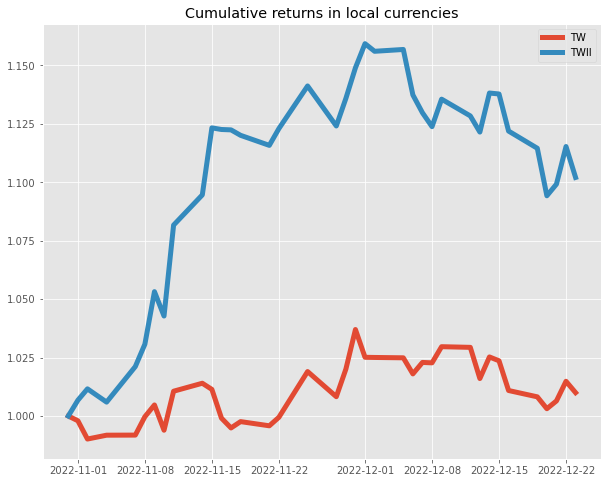

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('ggplot')

# first day of trading
start = '2022-10-31'

df = pd.read_csv('weight_agg.csv')

def strategy_return(cty):
    c = cty * 2
    w = df.iloc[:,c:c+2].dropna()

    idx_list = ["^GSPC","^TWII","^GDAXI","^N225"]
    fx_list = ["usdusd=x","twdusd=x","eurusd=x","jpyusd=x"]

    idxname_list = ["SP500","TWII","DAX","N225"]
    cty_list = ["US", "TW", "DE", "JP"]

    # Download local index
    print(idx_list[cty])
    idx = yf.download(idx_list[cty], interval="1d", start=start)['Close'].dropna()
    idx = idx.loc[start:]

    # Download Local currency to USD rate
    print(fx_list[cty])
    fx = yf.download(fx_list[cty], interval="1d", start=start)['Close'].dropna()

    # Download stock prices
    stk = yf.download(w.iloc[:,0].to_list(), interval="1d", start=start)['Close'].dropna()
    stk = stk.loc[start:]

    # Compute local cumulative returns
    stkcret_lcl = stk/stk.iloc[0,:]
    idxcret_lcl = idx/idx.iloc[0]

    # Compute index and stock values in USD
    if fx_list[cty] == "usdusd=x":
        idx_usd = idx.dropna()
        stk_usd = stk.dropna()
    else:
        idx_usd = idx.multiply(fx, axis=0).dropna()
        stk_usd = stk.multiply(fx, axis=0).dropna()

    # Compute USD cumulative returns
    idxcret_usd = idx_usd/idx_usd.iloc[0]
    stkcret_usd = stk_usd/stk_usd.iloc[0,:]

    wgt = w.iloc[:,1]
    wgt.index = stkcret_usd.columns

    # Compute strategy cumulative returns
    strcret_lcl = stkcret_lcl.multiply(wgt, axis=1).sum(axis=1)
    strcret_usd = stkcret_usd.multiply(wgt, axis=1).sum(axis=1)

    cret = pd.DataFrame()
    cret[idxname_list[cty]] = idxcret_lcl 
    cret[idxname_list[cty] + '_usd'] = idxcret_usd
    cret[cty_list[cty]] = strcret_lcl 
    cret[cty_list[cty] + '_usd'] = strcret_usd

    return cret

# Country code - 0: US, 1: TW, 2: DE, 3: JP
grpUS = strategy_return(0)
grpTW = strategy_return(1)
grpDE = strategy_return(2)
grpJP = strategy_return(3)

grpALL = pd.concat([grpUS, grpTW, grpDE, grpJP], axis=1).dropna()

plt.figure(figsize=(10,8))
plt.plot(grpALL[['TW', 'TWII']], linewidth=5)
plt.legend(['TW', 'TWII'])
plt.title('Cumulative returns in local currencies')
plt.show()

In [15]:
import statsmodels.api as sm

regdf = grpTW.pct_change().dropna()

Y = regdf.iloc[:,2]
X = sm.add_constant(regdf.iloc[:,0])

res = sm.OLS(Y,X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     TW   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     25.95
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           9.88e-06
Time:                        12:20:28   Log-Likelihood:                 148.30
No. Observations:                  40   AIC:                            -292.6
Df Residuals:                      38   BIC:                            -289.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.700      0.4

In [16]:
regdf.mean()

TWII        0.002550
TWII_usd    0.003726
TW          0.000377
TW_usd      0.001531
dtype: float64

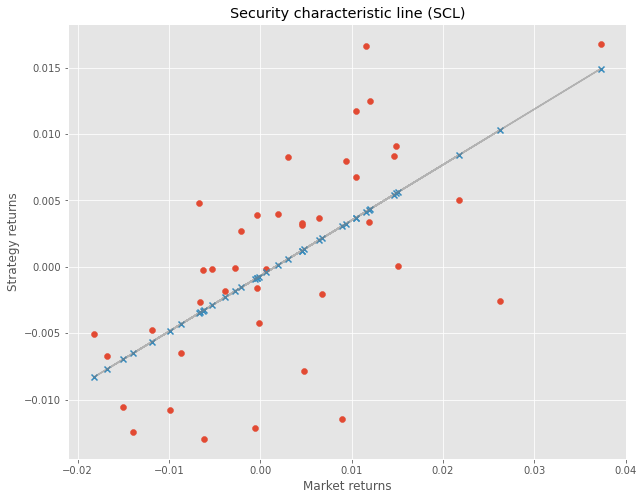

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(regdf.iloc[:,0], regdf.iloc[:,2])
plt.scatter(regdf.iloc[:,0], res.fittedvalues, marker='x')
plt.ylabel('Strategy returns')
plt.xlabel('Market returns')
plt.title('Security characteristic line (SCL)')
plt.plot(regdf.iloc[:,0], res.fittedvalues, color='gray', alpha=0.5)
plt.show()

In [18]:
#sharpe ratio
AR = regdf.mean()
SD = regdf.std()
SR = AR/SD
SR*(252)/(252**0.5)  #annualized



TWII        3.407806
TWII_usd    3.823151
TW          0.766612
TW_usd      2.247815
dtype: float64

In [19]:
#treynor ratio
TR = AR[2]/res.params[1]
TR*252  # annualized
TR2 = AR[0]
print(TR*252,TR2*252)

0.2269140152266781 0.642581903057016


In [23]:
import pandas as pd
factors =pd.read_csv('FACTOR.csv')
factors.head()
factors['Date'] = pd.to_datetime(factors['Date'])
factors = factors.set_index('Date')
factors = factors.sort_index()
factors = factors.pct_change().dropna()


In [26]:
import statsmodels.api as sm
from scipy.optimize import minimize # optimizers
from scipy.optimize import Bounds # optimizers
from scipy.stats import t
Y = regdf.iloc[:,2]
X = sm.add_constant(factors.iloc[:,:4])


#X = factors.iloc[:,:4]
N = X.shape[1]
b0 = np.ones(N)/N

def sse(b0, Y, X):
    sse = ((Y - X @ b0) ** 2).sum()
    return sse

# no short selling constraint:
bounds = Bounds(0, 1)

# investment sum up to 1 constraint:
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

#res = minimize(sse, b0, method='SLSQP', args=(Y, X), options={'disp': True, 'ftol': 1e-12})
res = minimize(sse, b0, method='SLSQP', args=(Y, X), constraints=cons, options={'disp': True, 'ftol': 1e-12}, bounds=bounds)

dof = len(Y)-N
covB = np.linalg.inv(X.T @ X) * res.fun/dof

result = pd.DataFrame(index=X.columns)
result['coef'] = np.round(res.x, 4)
result['std err'] = np.round(np.diag(covB)**0.5, 3)
result['t'] = np.round(result['coef']/result['std err'], 3)
result['P>|t|'] = np.round(2*(1 - t.cdf(abs(result['t']), dof)), 3)
result

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005095542020694906
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11


,coef,std err,t,P>|t|
const,0.0000,0.002,0.000,1.000
Yuanta,0.4452,0.191,2.331,0.025
Blue Chip,0.1430,0.136,1.051,0.300
Small-Mid,0.4118,0.150,2.745,0.009


In [10]:
regdf

,TWII,TWII_usd,TW,TW_usd
Date,,,,
2022-11-01,0.006754,0.002580,-0.002041,-0.006178
2022-11-02,0.004829,0.008698,-0.007828,-0.004008
2022-11-03,-0.008669,-0.012466,-0.006514,-0.010318
2022-11-04,0.003089,0.006131,0.008229,0.011286
2022-11-07,0.015124,0.019915,0.000039,0.004758
2022-11-08,0.009379,0.014101,0.007936,0.012652
2022-11-09,0.021805,0.023740,0.005029,0.006933
2022-11-10,-0.009902,-0.013693,-0.010761,-0.014549
2022-11-11,0.037308,0.054155,0.016796,0.033310


In [11]:
df=[]
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
df = yf.download(["2330.TW","2454.TW","2308.TW","2881.TW","2882.TW","2886.TW","1513.TW","6443.TW","3576.TW","2412.TW","3045.TW","4904.TW","3252.TWO","2756.TWO","2736.TWO","9921.TW","9914.TW","5306.TW"], interval="1d", period="5y")
prc = df['Adj Close']
ret = prc.pct_change().dropna()

[*********************100%***********************]  18 of 18 completed


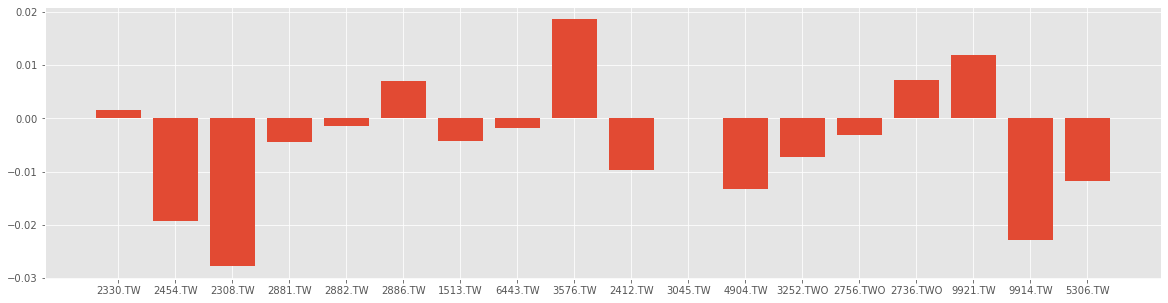

In [12]:
ret_oos = ret.loc["2022-10-31":"2022-12-25"]
ret_oos = ret_oos.sort_index()
ret_oos
x=["2330.TW","2454.TW","2308.TW","2881.TW","2882.TW","2886.TW","1513.TW","6443.TW","3576.TW","2412.TW","3045.TW","4904.TW","3252.TWO","2756.TWO","2736.TWO","9921.TW","9914.TW","5306.TW"]
h=ret.loc["2022-12-23"]
plt.figure(figsize=(20, 5))
plt.bar(x,h)
plt.show()